# 問題
コーパスにおける単語の出現頻度順位を横軸、その出現頻度を縦軸として、両対数グラフをプロットせよ。

In [ ]:
import gzip
import json
import html
import re
import MeCab
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


import re, html

def remove_markup(text: str, *, drop_numbers: bool = True, drop_punct: bool = True) -> str:
    """
    Wikipediaテキストから主要なマークアップ/タグ/参照/URLを除去し、
    仕上げに（オプションで）数字・記号も除去して整形したプレーンテキストを返す。
    """
    if not isinstance(text, str):
        return ""
    text = html.unescape(text)

    patterns = [
        # --- 巨大ブロック ---
        (r'(?m)^\s*\{\{\s*基礎情報[\s\S]*?^\s*\}\}\s*$', "", re.MULTILINE),  # 基礎情報テンプレ
        (r'\{\|[\s\S]*?\|\}', "", 0),  # 表(table)

        # --- ハットノート ---
        (r'\{\{\s*(?:otheruses|Otheruses[^|}]*)\s*\|[^}]*\}\}', "", re.IGNORECASE),

        # --- カテゴリ ---
        (r'\[\[(?:Category|カテゴリ):[^\]]+\]\]', "", re.IGNORECASE),

        # --- 参照・脚注 ---
        (r'(?m)<ref[^>]*>.*?$', "", 0),
        (r'<ref[^>]*>.*?</ref>', "", re.DOTALL | re.IGNORECASE),
        (r'<ref[^>]*/>', "", re.IGNORECASE),
        (r'<references\s*/?>', "", re.IGNORECASE),

        # --- 強調記法 ---
        (r"'''''(.*?)'''''", r"\1", 0),
        (r"'''(.*?)'''",     r"\1", 0),
        (r"''(.*?)''",       r"\1", 0),

        # --- 内部リンク ---
        (r"\[\[(?:ファイル|File|画像):[^|\]]+(?:\|[^|\]]+)*\|([^|\]=][^|\]]*)\]\]", r"\1", 0),
        (r"\[\[(?:ファイル|File|画像):([^\]|]+)\]\]", r"\1", 0),
        (r"\[\[[^|\]]+\|([^\]]+)\]\]", r"\1", 0),                  # [[page|表示]]
        (r"\[\[([^\]|#]+)(?:#[^\]]+)?\]\]", r"\1", 0),              # [[page#節]]
        (r"\[\[:[a-z0-9\-]+:[^|\]]+\|([^\]]+)\]\]", r"\1", re.IGNORECASE),
        (r"\[\[:[a-z0-9\-]+:([^\]#|]+)(?:#[^\]]+)?\]\]", r"\1", re.IGNORECASE),

        # --- テンプレ（代表的置換） ---
        (r"\{\{lang\|[a-z0-9\-]+\|([^}]+)\}\}", r"\1", re.IGNORECASE),
        (r"\{\{lang-[a-z0-9\-]+\|([^}]+)\}\}", r"\1", re.IGNORECASE),
        (r"\{\{(?:ill2?|仮リンク)\|([^|}]+)\|[^}]*\}\}", r"\1", re.IGNORECASE),
        (r"\{\{flagicon\|([^|}]+)\}\}", r"\1", re.IGNORECASE),
        (r"\{\{convert\|([^|}]+)\|[^}]*\}\}", r"\1", re.IGNORECASE),

        # --- HTML ---
        (r"<br\s*/?>", "\n", re.IGNORECASE),
        (r"</?(?:small|sup|sub|span|div|center|nowiki|ref)[^>]*>", "", re.IGNORECASE),
        (r"<[^>]+>", "", 0),

        # --- URL ---
        (r"https?://[^\s]+", "", re.IGNORECASE),
        (r"www\.[^\s]+",     "", re.IGNORECASE),

        # --- 孤立/単純テンプレの後始末 ---
        (r"\{\{[^{}]+\}\}", "", 0),
        (r"\{\{", "", 0),
        (r"\}\}", "", 0),
        (r"\[\[|\]\]", "", 0),  # 余った[[や]]の除去
    ]

    # 収束するまで削除（入れ子対応のため）
    changed = True
    while changed:
        old = text
        for pat, repl, flg in patterns:
            text = re.sub(pat, repl, text, flags=(flg | re.DOTALL))
        changed = (text != old)

    # --- 後処理（見出しの=を落として本文化） ---
    text = text.replace("\\n", "\n")
    text = re.sub(r'(?m)^\s*={2,}\s*(.*?)\s*={2,}\s*$', r'\n\1\n', text)

    # --- ここから任意：数字・記号の除去 ---
    if drop_numbers:
        # 半角・全角の数字を削除
        text = re.sub(r"[0-9０-９]+", "", text)

    if drop_punct:
        # 主要な和文記号・括弧・ASCII記号の多くを削除
        punct_class = r"[、。・（）「」『』【】［\[\]］〔〕〈〉《》＜＞\(\){}〈〉《》【】\-‐-‒–—―…‥:：；;!！\?？、。,.，．/／\\|｜_＿~～^＾`´'’\"“”『』￥¥＋+＝=＊*％%＃#＠@＆&]"
        text = re.sub(punct_class, "", text)

    # --- 空白整形 ---
    text = re.sub(r"[ \t\u3000]+", " ", text)  # 半角/全角スペースを1つに
    text = re.sub(r"\n{3,}", "\n\n", text)     # 連続改行を2つまで
    text = re.sub(r"[ \t]+\n", "\n", text)     # 行末スペース削除
    text = text.strip()

    return text

def count_words():
    word_counter = Counter()
    with gzip.open("Jawiki Country.json.gz", "rt", encoding="utf-8") as f:
        for line in f:
            article = json.loads(line)  # JSONをPythonの辞書に変換
            text = article["text"]
            text = remove_markup(text)
            mecab = MeCab.Tagger("-Owakati")
            nodes = mecab.parseToNode(text)
            while nodes:
                word_counter[nodes.surface] += 1
                nodes = nodes.next 
        word_counter = dict(word_counter)
    return word_counter

def sort():
    word_counter = count_words()
    sorted_dict = sorted(word_counter.items(), key=lambda x: x[1], reverse=True)
    return dict(sorted_dict)

# -----Keyがwordなので順位に変える------
def change_key_to_number():
    sorted_dict = sort()
    i = 1
    d = {}
    for word, count in sorted_dict.items():
        d[i] = sorted_dict[word]
        i +=1
    return d

def plot_dict_loglog():
    data = change_key_to_number()
    # キーと値をそれぞれ取り出す
    x = list(data.keys())
    y = list(data.values())
    plt.rcParams['font.family'] = 'Hiragino Sans'
    plt.figure(figsize=(10, 6))
    plt.grid(True, which="both", ls="--", lw=0.5)
    plt.loglog(x, y)
    plt.xlabel(xlabel="順位")
    plt.ylabel(ylabel="値")
    plt.title( "頻度分布（両対数グラフ）")
    plt.show()

In [14]:
count_words()

{'': 496,
 'エジプト': 299,
 'アラブ': 440,
 '共和': 2741,
 '国': 6750,
 'きょう': 14,
 'わ': 17,
 'こく': 164,
 'جمهورية': 6,
 'مصر': 3,
 'العربية': 4,
 '通称': 524,
 'は': 41761,
 '中東': 182,
 '世界': 3008,
 'および': 687,
 '北': 802,
 'アフリカ': 986,
 'に': 50427,
 'ある': 9593,
 '首都': 1085,
 'カイロ': 21,
 '大陸': 426,
 'で': 27913,
 '北東': 208,
 '端': 33,
 '位置': 659,
 'し': 24313,
 '西': 711,
 'リビア': 120,
 '南': 886,
 'スーダン': 258,
 'の': 71613,
 'シナイ': 11,
 '半島': 399,
 'イスラエル': 387,
 'ガザ': 34,
 '地区': 413,
 'と': 27344,
 '国境': 670,
 'を': 30718,
 '接する': 93,
 '地中': 198,
 '海東': 11,
 '紅海': 34,
 '面し': 96,
 'て': 29017,
 'いる': 10680,
 '南北': 241,
 '流れる': 56,
 'ナイル': 70,
 '川': 823,
 '河谷': 7,
 'デルタ': 69,
 '地帯': 373,
 'ほか': 684,
 '国土': 561,
 '大': 1360,
 '部分': 258,
 '以上': 676,
 'が': 35860,
 '砂漠': 229,
 '国号': 52,
 '正式': 428,
 '名称': 370,
 'アラビア': 215,
 '語': 4595,
 'ラテン': 132,
 '翻字': 2,
 '標準': 81,
 'ミスルエジプト': 1,
 '方言': 197,
 '口語': 19,
 'マスルコプト': 1,
 'Ⲭⲏⲙⲓ': 1,
 'Khemi': 1,
 'ケーミ': 1,
 'ミス': 12,
 'ル': 87,
 '古代': 219,
 'から': 7049,
 'セム': 7,
 

In [18]:
sort()

{'の': 71613,
 'に': 50427,
 'は': 41761,
 'が': 35860,
 'を': 30718,
 'て': 29017,
 'た': 28489,
 'で': 27913,
 'と': 27344,
 'し': 24313,
 '年': 16181,
 'れ': 11187,
 'いる': 10680,
 'さ': 10079,
 'ある': 9593,
 'も': 8775,
 'する': 7599,
 'から': 7049,
 '国': 6750,
 '人': 6592,
 'や': 5297,
 'な': 5286,
 'など': 4969,
 '語': 4595,
 '的': 4457,
 '日本': 3895,
 'なっ': 3661,
 'こと': 3583,
 'れる': 3554,
 '月': 3369,
 'その': 3075,
 'い': 3054,
 '世界': 3008,
 'あり': 2862,
 '島': 2823,
 '政府': 2815,
 '共和': 2741,
 '大統領': 2723,
 '日': 2672,
 '者': 2593,
 'より': 2552,
 'ため': 2511,
 'ない': 2402,
 'よる': 2287,
 'この': 2211,
 '経済': 2195,
 'へ': 2193,
 'アメリカ': 2145,
 '第': 2139,
 'また': 2021,
 'おり': 2019,
 '独立': 2005,
 '州': 1978,
 '国民': 1918,
 '軍': 1899,
 '後': 1853,
 'フランス': 1829,
 'まで': 1815,
 '党': 1790,
 '地': 1776,
 'よっ': 1757,
 '国家': 1732,
 '政権': 1705,
 'イギリス': 1682,
 '地域': 1655,
 '化': 1646,
 '年月': 1618,
 'られ': 1600,
 '世紀': 1578,
 'あっ': 1563,
 '選挙': 1562,
 '関係': 1541,
 '系': 1538,
 '現在': 1532,
 '主義': 1501,
 '文化': 1494,
 '制': 1466,
 'もの': 1433,


In [24]:
change_key_to_number()

{1: 71613,
 2: 50427,
 3: 41761,
 4: 35860,
 5: 30718,
 6: 29017,
 7: 28489,
 8: 27913,
 9: 27344,
 10: 24313,
 11: 16181,
 12: 11187,
 13: 10680,
 14: 10079,
 15: 9593,
 16: 8775,
 17: 7599,
 18: 7049,
 19: 6750,
 20: 6592,
 21: 5297,
 22: 5286,
 23: 4969,
 24: 4595,
 25: 4457,
 26: 3895,
 27: 3661,
 28: 3583,
 29: 3554,
 30: 3369,
 31: 3075,
 32: 3054,
 33: 3008,
 34: 2862,
 35: 2823,
 36: 2815,
 37: 2741,
 38: 2723,
 39: 2672,
 40: 2593,
 41: 2552,
 42: 2511,
 43: 2402,
 44: 2287,
 45: 2211,
 46: 2195,
 47: 2193,
 48: 2145,
 49: 2139,
 50: 2021,
 51: 2019,
 52: 2005,
 53: 1978,
 54: 1918,
 55: 1899,
 56: 1853,
 57: 1829,
 58: 1815,
 59: 1790,
 60: 1776,
 61: 1757,
 62: 1732,
 63: 1705,
 64: 1682,
 65: 1655,
 66: 1646,
 67: 1618,
 68: 1600,
 69: 1578,
 70: 1563,
 71: 1562,
 72: 1541,
 73: 1538,
 74: 1532,
 75: 1501,
 76: 1494,
 77: 1466,
 78: 1433,
 79: 1399,
 80: 1393,
 81: 1370,
 82: 1360,
 83: 1354,
 84: 1346,
 85: 1334,
 86: 1332,
 87: 1307,
 88: 1279,
 89: 1278,
 90: 1266,
 91: 

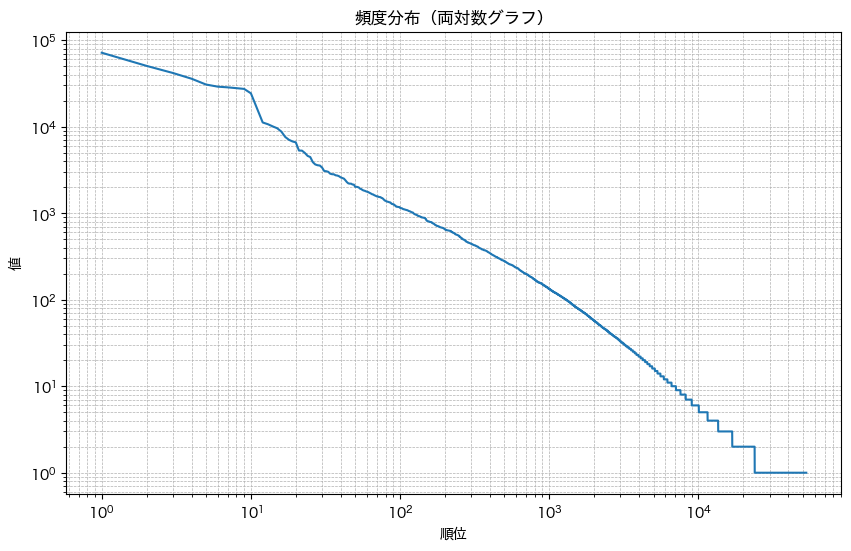

In [33]:
plot_dict_loglog()